In [17]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, jensenshannon
from scipy.stats import spearmanr
import numpy as np
from docopt import docopt
from scipy.stats import entropy
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sys
import pylab as plot
from sklearn.decomposition import PCA

### Pre-Soviet vs. Soviet

In [18]:
dataset = pd.read_csv('../dataset/dataset_0_DUREL_filtered_02.tsv', sep='\t')
dataset.head()

word  COMPARE  EARLIER  LATER  delta_later frequency_presov/sov
0   агентство     3.15     3.62   3.55        -0.07              842/333
1  богадельня     3.65     3.30   3.29        -0.01              442/190
2    больница     3.86     3.71   3.92         0.21            3337/6597
3       весна     3.58     3.55   3.60         0.05           5729/10250
4        вино     3.37     3.68   3.77         0.09            6499/6919

In [19]:
delta = {}
for pair in zip(dataset.word.tolist(), dataset.delta_later.tolist()):
    delta.update({pair[0]: abs(pair[1])})
# delta

In [20]:
compare = {}
for pair in zip(dataset.word.tolist(), dataset.COMPARE.tolist()):
    compare.update({pair[0]: abs(pair[1])})
# compare

In [21]:
target_words = dataset.word.tolist()

In [22]:
# token embeddings extracted using https://github.com/ltgoslo/simple_elmo

array0 = np.load('sep_embs_pre_0.npz')
print(len(array0))

array1 = np.load('sep_embs_sov_0.npz')
print(len(array1))

71
71


In [23]:
def cluster(usage_matrix, time_labels):
    usage_matrix = StandardScaler().fit_transform(usage_matrix)
    clustering = AffinityPropagation(damping=0.5, max_iter=200, convergence_iter=10,
                                     preference=None, affinity='euclidean',
                                    random_state=None).fit(usage_matrix)
    labels = clustering.labels_
    n_clusters = len(set(labels))
    # print(n_clusters)
    
    assert len(labels) == usage_matrix.shape[0] == len(time_labels)

    return n_clusters, labels, time_labels

In [25]:
def cluster_jsd(words, array0, array1):
    
    sense_distributions1 = {}
    sense_distributions2 = {}

    for word in words:
        # print(word)
        if array0[word].shape[0] > 1000:
            rand_indices = np.random.choice(array0[word].shape[0], 1000, replace=False)
            usage_matrix1 = array0[word][rand_indices]
        else:
            usage_matrix1 = array0[word]

        if array1[word].shape[0] > 1000:
            rand_indices = np.random.choice(array1[word].shape[0], 1000, replace=False)
            usage_matrix2 = array1[word][rand_indices]
        else:
            usage_matrix2 = array1[word]

        usage_matrix = np.vstack((usage_matrix1, usage_matrix2))
        time_labels = np.ones(usage_matrix.shape[0])
        time_labels[array0[word].shape[0]:] = 2

        num_senses_w, labels, time_labels = cluster(usage_matrix, time_labels)

        sense_distributions1[word] = np.zeros(num_senses_w)
        sense_distributions2[word] = np.zeros(num_senses_w)

        sense_label_ids = sorted(set(labels))
        assert num_senses_w == len(sense_label_ids)

        for sense_label_id in sense_label_ids:
            for cl_label, t_label in zip(labels, time_labels):
                if t_label == 1:
                    sense_distributions1[word][sense_label_id] += (
                        sense_label_id == cl_label)
                else:
                    sense_distributions2[word][sense_label_id] += (
                        sense_label_id == cl_label)

        for sense_label_id in range(num_senses_w):
            if sum(sense_distributions1[word]) > 0:
                sense_distributions1[word][sense_label_id] /= sum(
                    sense_distributions1[word])
            if sum(sense_distributions2[word]) > 0:
                sense_distributions2[word][sense_label_id] /= sum(
                    sense_distributions2[word])
    
    jsd_scores = {}
    for word in target_words:
        p = sense_distributions1[word]
        q = sense_distributions2[word]
        jsd_scores[word] = jensenshannon(np.asarray(p), np.asarray(q))
    
    return jsd_scores

In [26]:
jsd = cluster_jsd(target_words, array0, array1)

/home/julia/.local/lib/python3.7/site-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


In [27]:
jsd_v = []
delta_v = []
compare_v = []
for word in target_words:
    jsd_v.append(jsd[word])
    delta_v.append(delta[word])
    compare_v.append(compare[word])

In [28]:
coef, p = spearmanr(jsd_v, delta_v, nan_policy='omit')
print('Results Jensen–Shannon divergence vs. Δlater values:')
print('Spearmans correlation coefficient: %.3f' % coef)
print('p=%.3f' % p)

Results Jensen–Shannon divergence vs. Δlater values:
Spearmans correlation coefficient: -0.073
p=0.729


In [29]:
coef, p = spearmanr(jsd_v, compare_v, nan_policy='omit')
print('Results Jensen–Shannon divergence vs. COMPARE values:')
print('Spearmans correlation coefficient: %.3f' % coef)
print('p=%.3f' % p)

Results Jensen–Shannon divergence vs. COMPARE values:
Spearmans correlation coefficient: 0.066
p=0.755


### PCA visualization

In [30]:
def pic(emb):
    array = emb
    print('number of points: {}'.format(array.shape[0]))

    embedding = PCA(n_components=2)
    y = embedding.fit_transform(array)

    xpositions = y[:, 0]
    ypositions = y[:, 1]

    plot.clf()

    plot.scatter(xpositions, ypositions, 5, marker='*', color='green')
    plot.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plot.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    # plot.title("{} in {}'s".format(word, year))
    #out = "{}_{}".format(word, year)

    #plot.savefig('раскрутка0' + 'PCA.png', dpi=600, bbox_inches='tight')
    plot.show()
    plot.close()
    plot.clf()

агентство
number of points: 1030


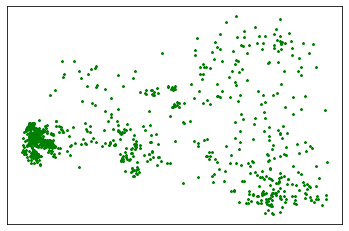

number of points: 383


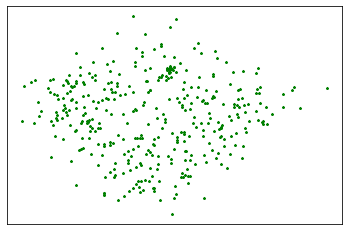

богадельня
number of points: 485


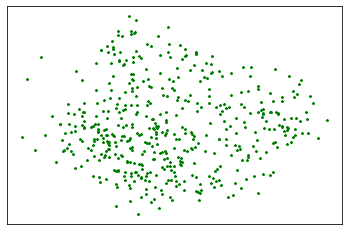

number of points: 204


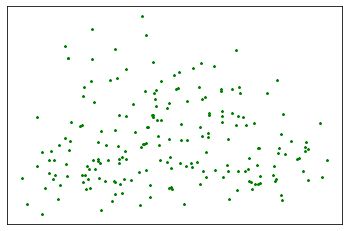

больница
number of points: 3480


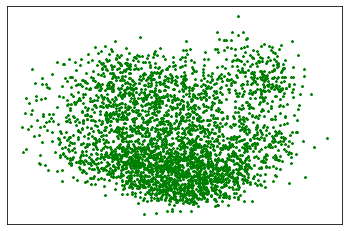

number of points: 6709


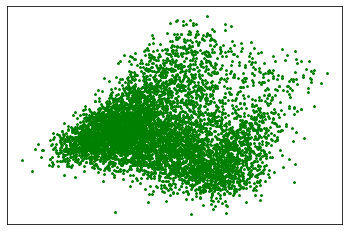

весна
number of points: 6466


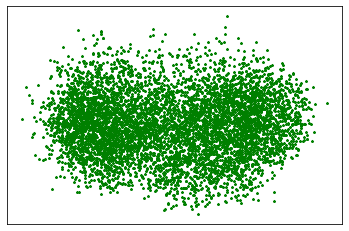

number of points: 11808


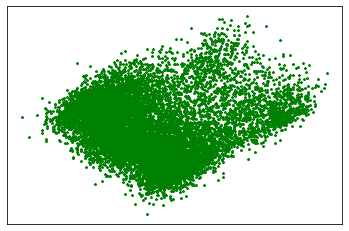

вино
number of points: 6834


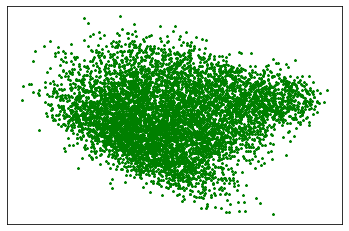

number of points: 7385


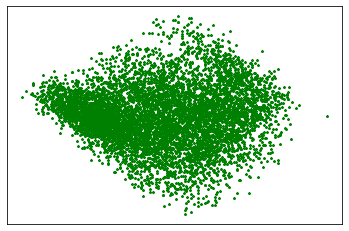

вывеска
number of points: 881


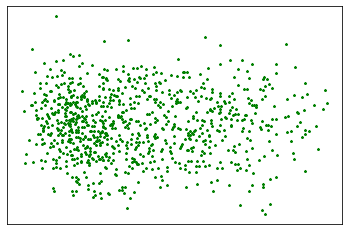

number of points: 1646


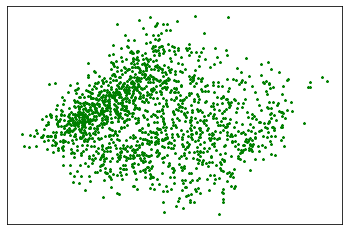

декрет
number of points: 267


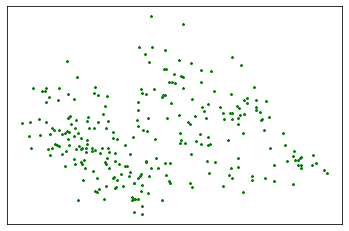

number of points: 996


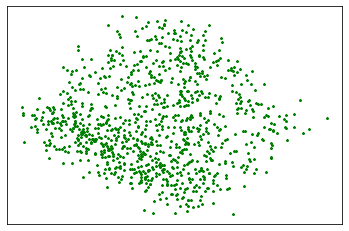

дождь
number of points: 7159


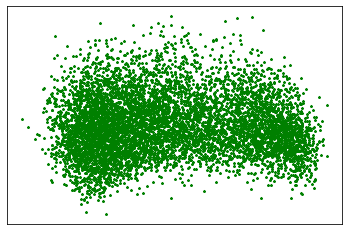

number of points: 12616


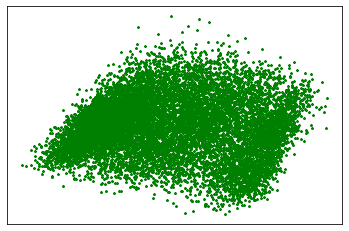

дума
number of points: 8195


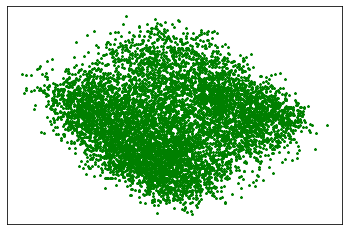

number of points: 8220


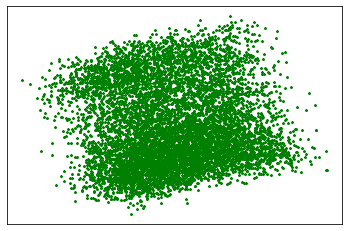

заключенный
number of points: 1306


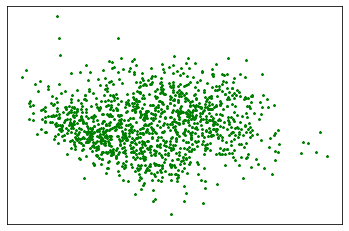

number of points: 3564


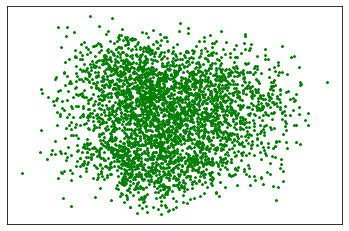

защитник
number of points: 2259


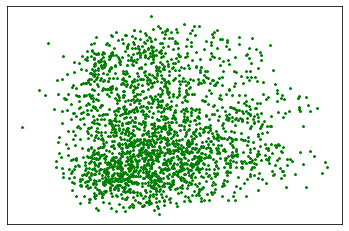

number of points: 2207


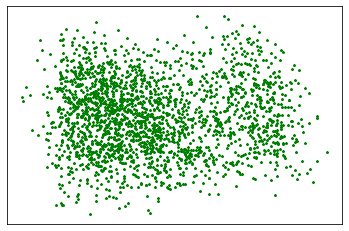

знатный
number of points: 3710


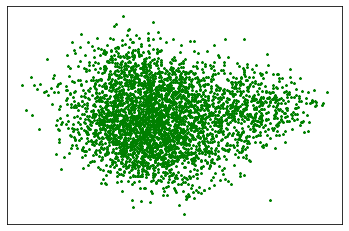

number of points: 1212


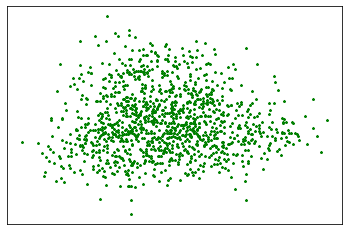

казенный
number of points: 4276


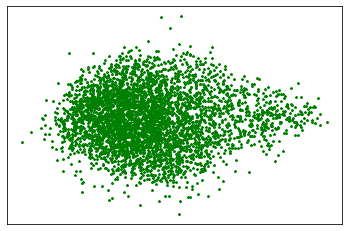

number of points: 2676


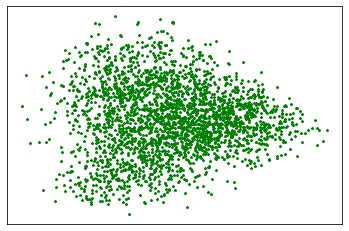

классный
number of points: 1022


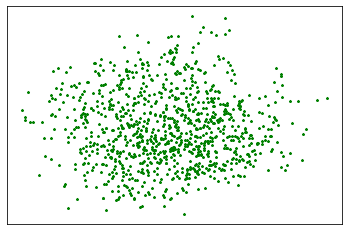

number of points: 1229


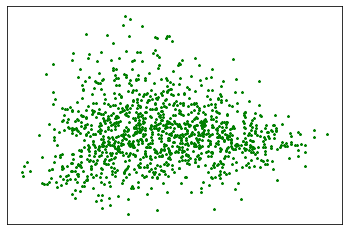

клиника
number of points: 467


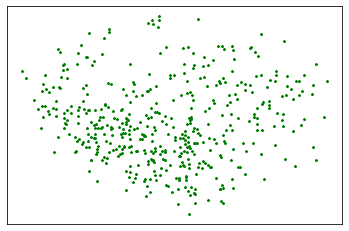

number of points: 1153


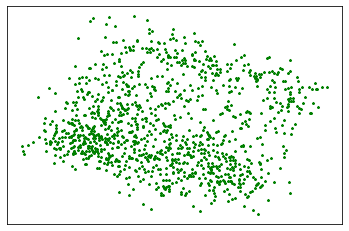

комиссар
number of points: 983


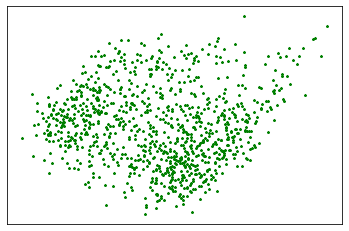

number of points: 6466


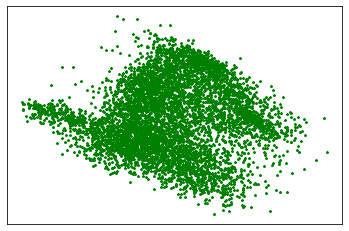

мазь
number of points: 308


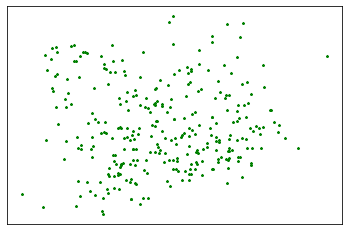

number of points: 547


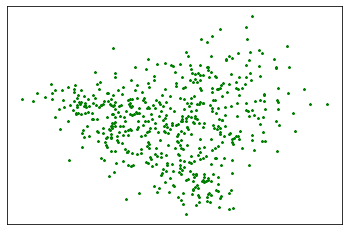

мама
number of points: 5342


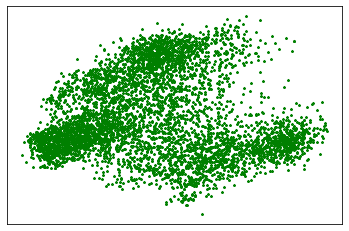

number of points: 25346


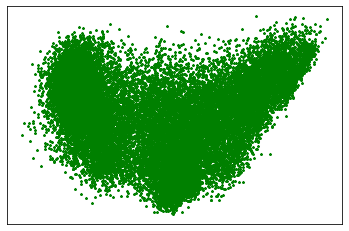

машина
number of points: 4268


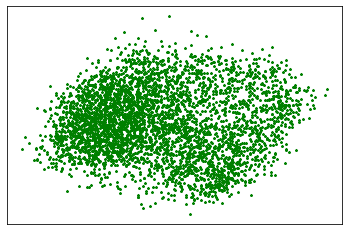

number of points: 36146


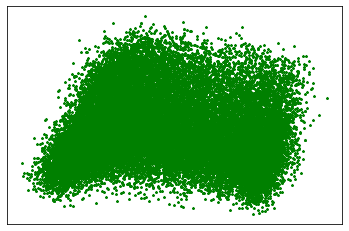

молодец
number of points: 4596


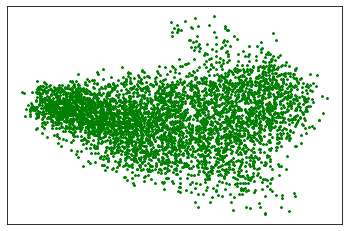

number of points: 4172


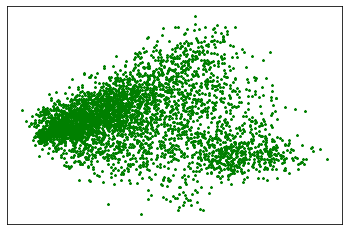

насаждение
number of points: 131


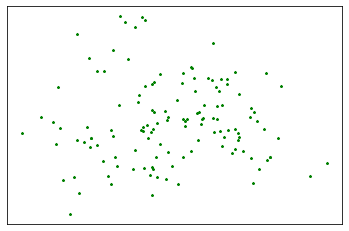

number of points: 416


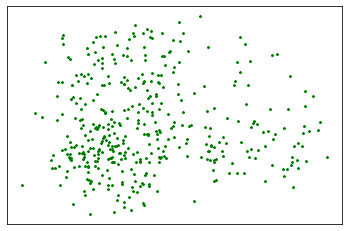

отдел
number of points: 2275


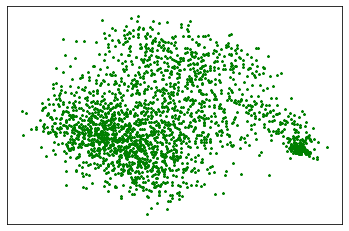

number of points: 8730


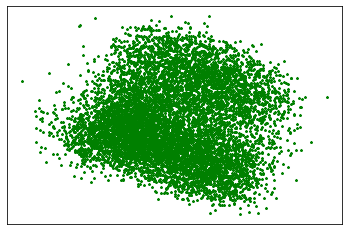

отделение
number of points: 5432


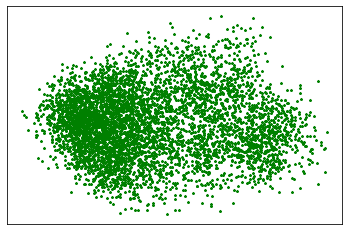

number of points: 7005


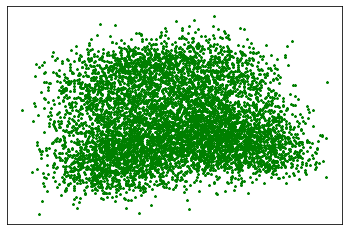

отрывок
number of points: 1327


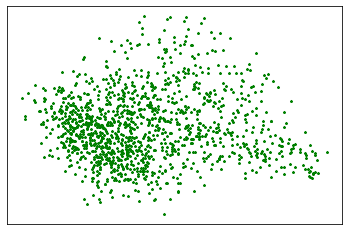

number of points: 1977


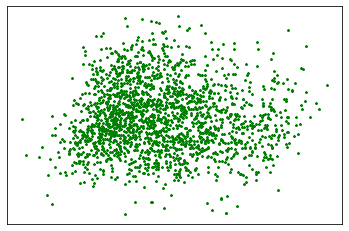

пакет
number of points: 1160


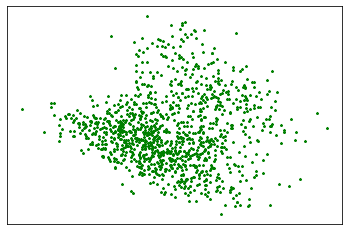

number of points: 2548


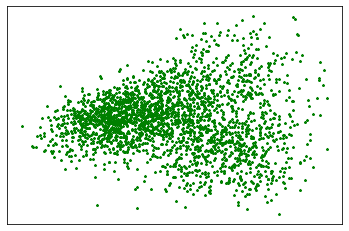

палата
number of points: 5558


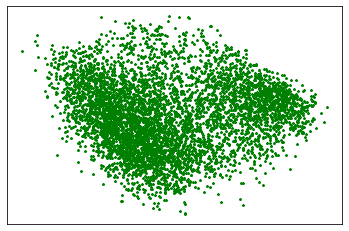

number of points: 4393


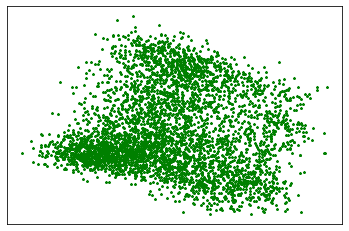

передовой
number of points: 1690


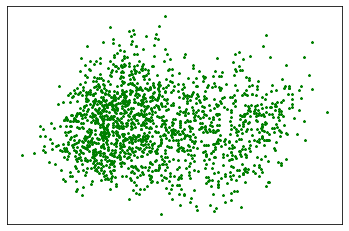

number of points: 3862


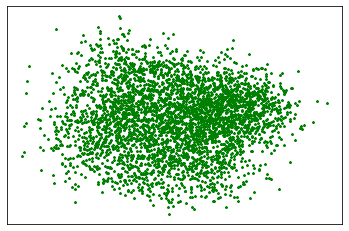

пионер
number of points: 197


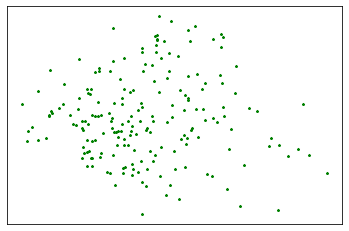

number of points: 2241


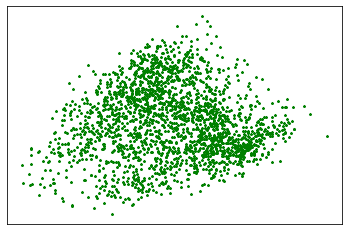

правитель
number of points: 2281


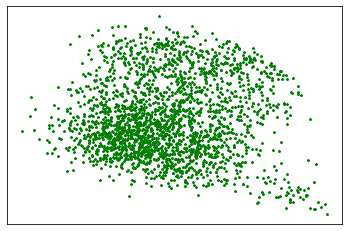

number of points: 1542


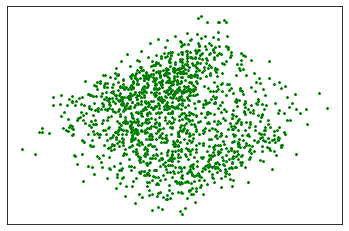

привет
number of points: 990


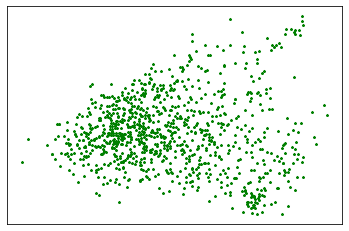

number of points: 3537


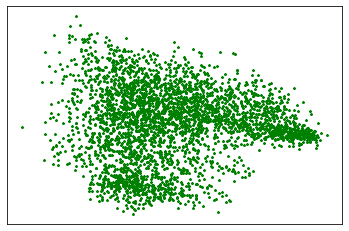

присутствие
number of points: 7357


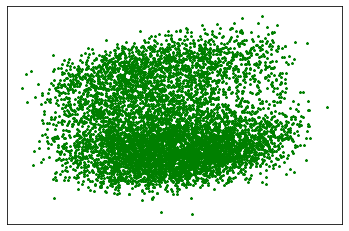

number of points: 5527


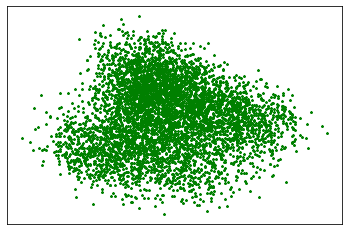

пружина
number of points: 669


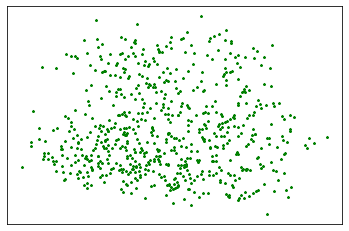

number of points: 1380


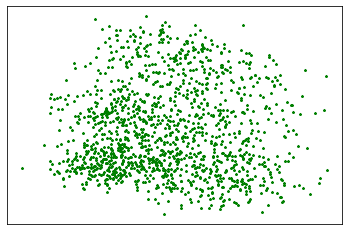

свалка
number of points: 329


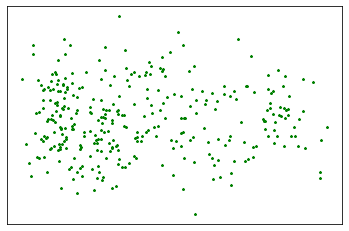

number of points: 804


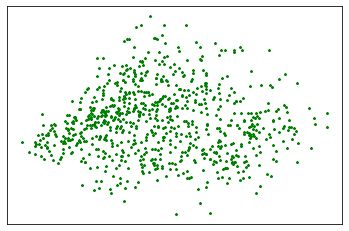

сволочь
number of points: 632


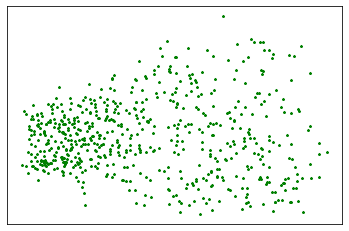

number of points: 2876


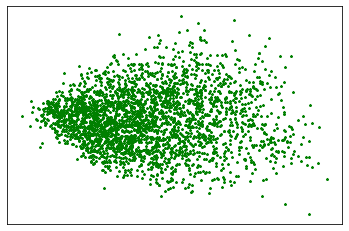

секция
number of points: 130


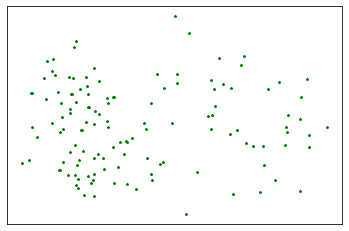

number of points: 2028


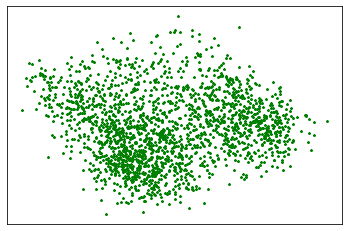

собор
number of points: 5384


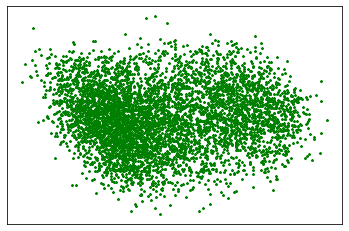

number of points: 5048


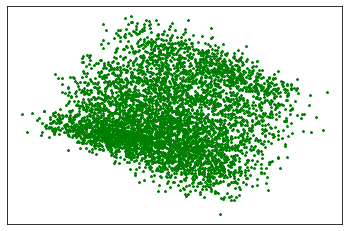

стиль
number of points: 1469


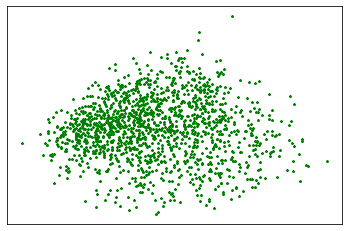

number of points: 6113


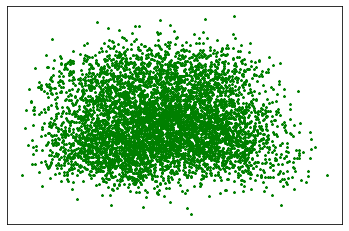

тетка
number of points: 3908


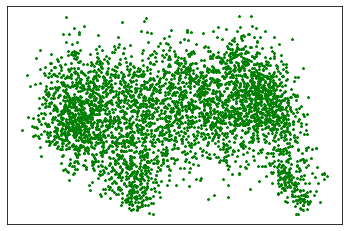

number of points: 4370


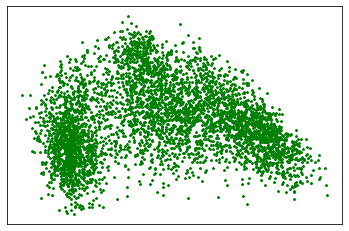

трибунал
number of points: 202


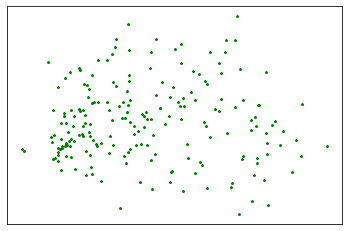

number of points: 682


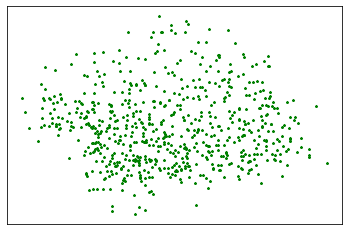

тройка
number of points: 1880


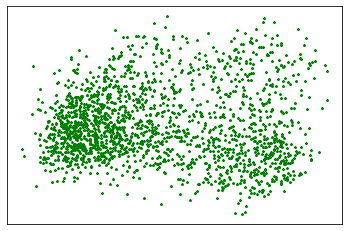

number of points: 2109


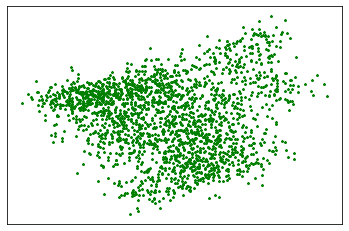

трубка
number of points: 3315


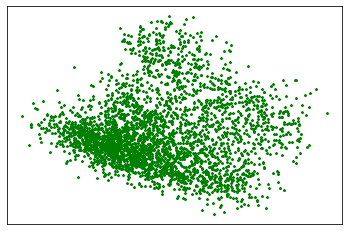

number of points: 9135


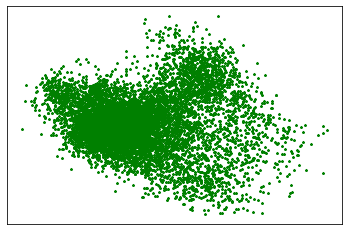

уклон
number of points: 95


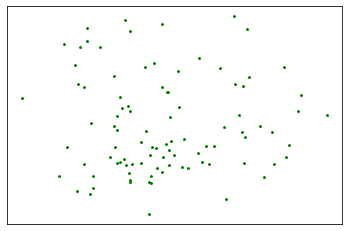

number of points: 1051


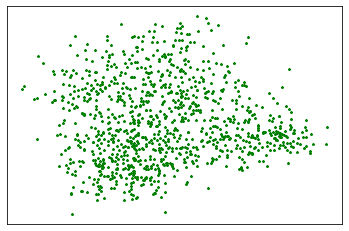

управа
number of points: 2847


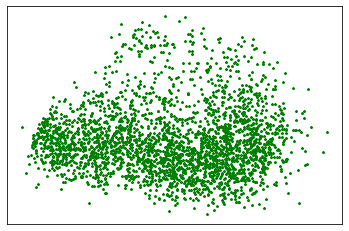

number of points: 746


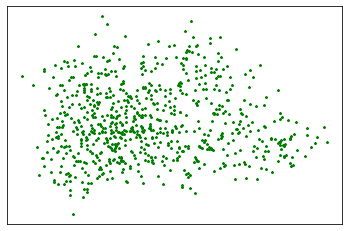

управление
number of points: 6292


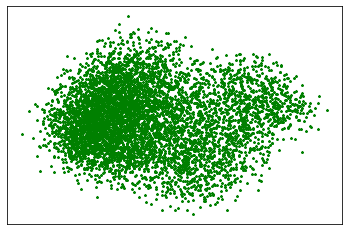

number of points: 10273


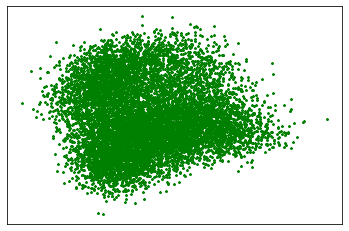

участок
number of points: 3106


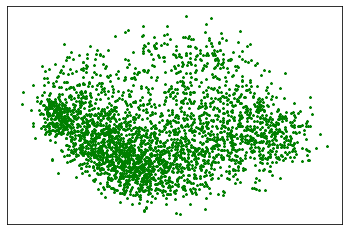

number of points: 10010


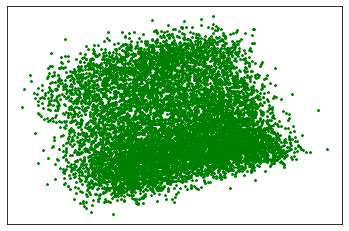

червяк
number of points: 350


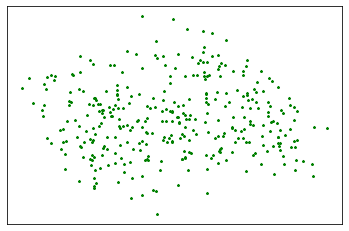

number of points: 546


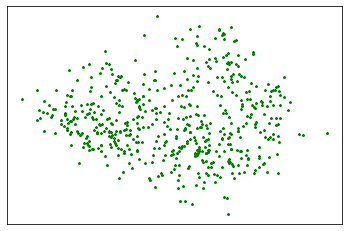

элемент
number of points: 4736


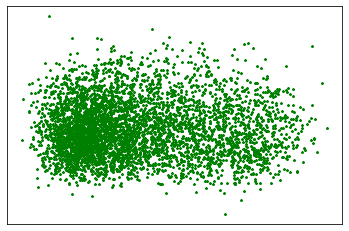

number of points: 10207


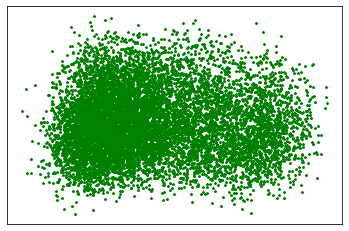

юношество
number of points: 560


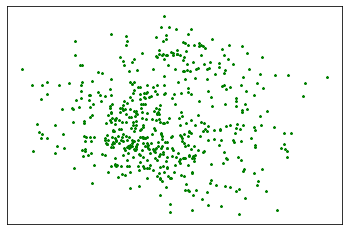

number of points: 259


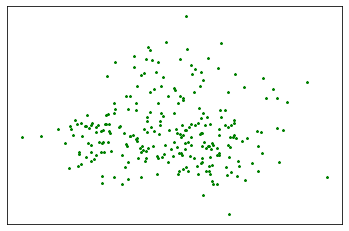

<Figure size 432x288 with 0 Axes>

In [31]:
for word in target_words:
    print(word)
    pic(array0[word])
    pic(array1[word])

### Soviet vs. Post-Soviet

In [32]:
dataset = pd.read_csv('../dataset/dataset_1_DUREL_filtered_02.tsv', sep='\t')
dataset.head()

word  COMPARE  EARLIER  LATER  delta_later frequency_sov/postsov
0   ателье     3.29     3.30   3.19        -0.11               288/326
1  блочный     2.15     2.57   2.63         0.06                67/157
2   боевик     2.25     3.28   2.82        -0.46              231/2918
3  ботаник     2.52     3.20   2.16        -1.04               410/219
4    взлом     3.26     3.40   3.03        -0.37                 99/99

In [33]:
delta = {}
for pair in zip(dataset.word.tolist(), dataset.delta_later.tolist()):
    delta.update({pair[0]: abs(pair[1])})
# delta

In [34]:
compare = {}
for pair in zip(dataset.word.tolist(), dataset.COMPARE.tolist()):
    compare.update({pair[0]: abs(pair[1])})
# compare

In [35]:
target_words = dataset.word.tolist()

In [36]:
# token embeddings extracted using https://github.com/ltgoslo/simple_elmo

array0 = np.load('sep_embs_sov_1.npz')
print(len(array0))

array1 = np.load('sep_embs_post_1.npz')
print(len(array1))

69
69


In [37]:
jsd = cluster_jsd(target_words, array0, array1)

/home/julia/.local/lib/python3.7/site-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)


In [38]:
jsd_v = []
delta_v = []
compare_v = []
for word in target_words:
    jsd_v.append(jsd[word])
    delta_v.append(delta[word])
    compare_v.append(compare[word])

In [39]:
coef, p = spearmanr(jsd_v, delta_v, nan_policy='omit')
print('Results Jensen–Shannon divergence vs. Δlater values:')
print('Spearmans correlation coefficient: %.3f' % coef)
print('p=%.3f' % p)

Results Jensen–Shannon divergence vs. Δlater values:
Spearmans correlation coefficient: 0.009
p=0.956


In [40]:
coef, p = spearmanr(jsd_v, compare_v, nan_policy='omit')
print('Results Jensen–Shannon divergence vs. COMPARE values:')
print('Spearmans correlation coefficient: %.3f' % coef)
print('p=%.3f' % p)

Results Jensen–Shannon divergence vs. COMPARE values:
Spearmans correlation coefficient: -0.096
p=0.559


### PCA visualization

ателье
number of points: 297


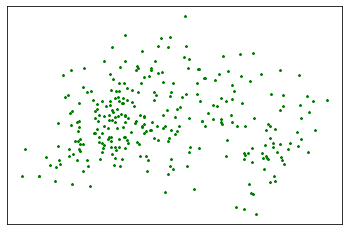

number of points: 330


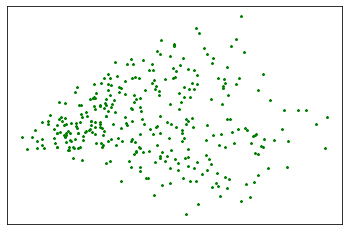

блочный
number of points: 69


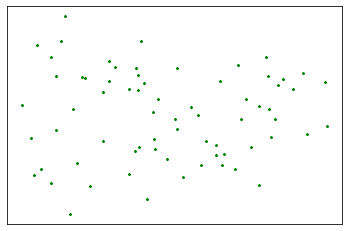

number of points: 158


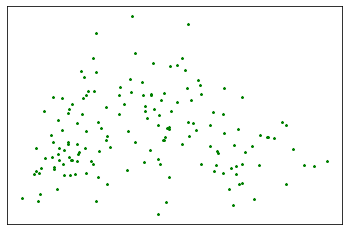

боевик
number of points: 238


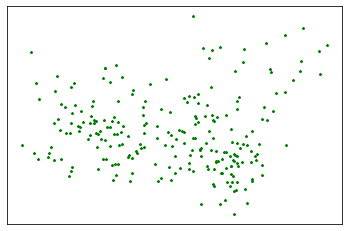

number of points: 2999


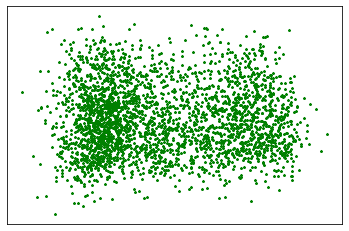

ботаник
number of points: 424


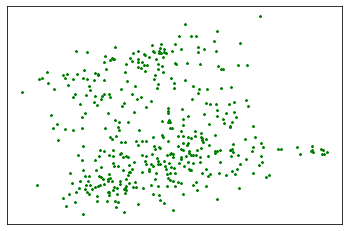

number of points: 229


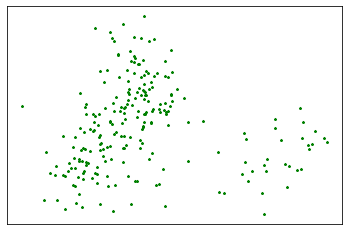

взлом
number of points: 103


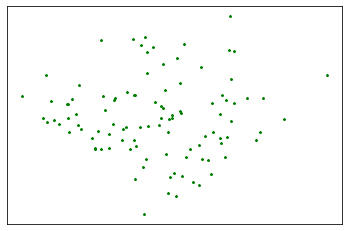

number of points: 102


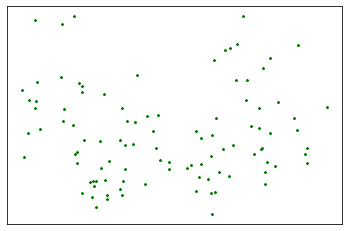

выплеск
number of points: 16


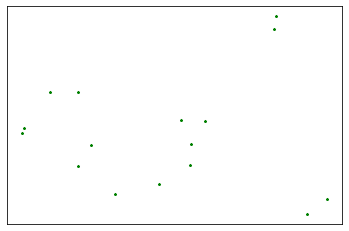

number of points: 45


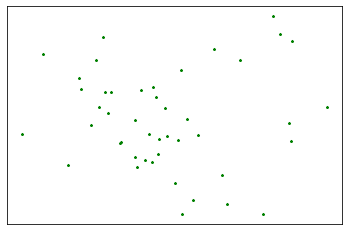

высоколобый
number of points: 48


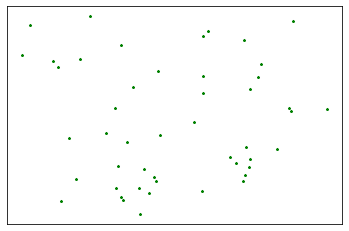

number of points: 103


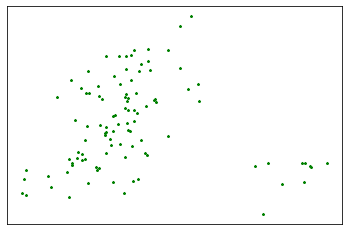

вышка
number of points: 1069


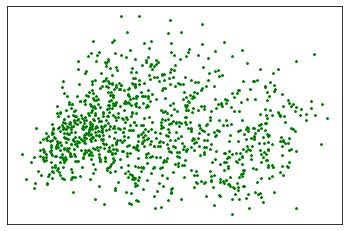

number of points: 770


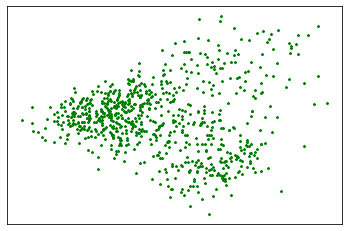

гильдия
number of points: 133


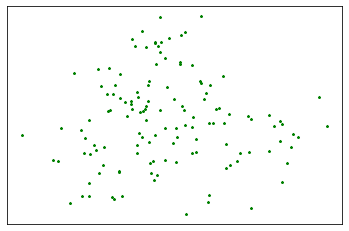

number of points: 323


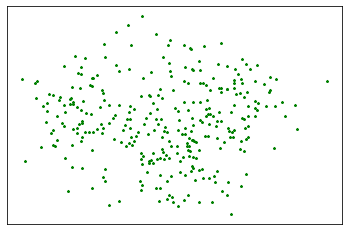

глянец
number of points: 173


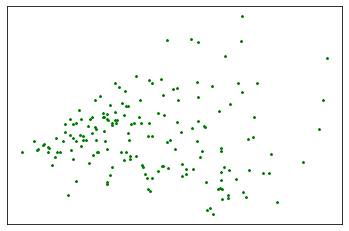

number of points: 155


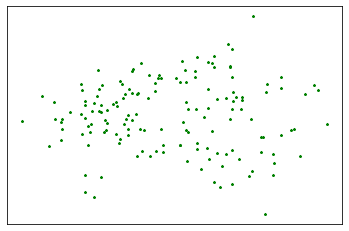

голубой
number of points: 10025


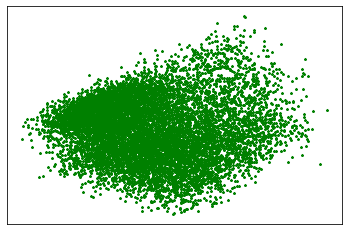

number of points: 5157


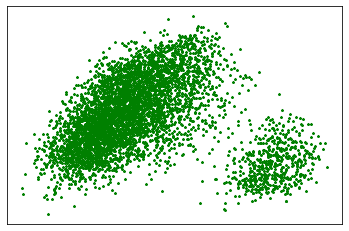

двушка
number of points: 77


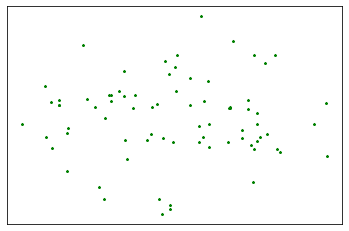

number of points: 103


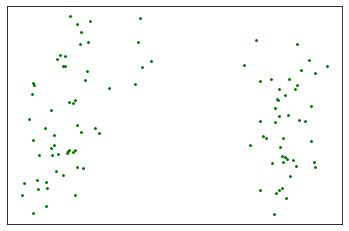

дивизион
number of points: 1592


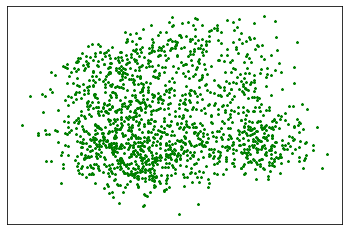

number of points: 823


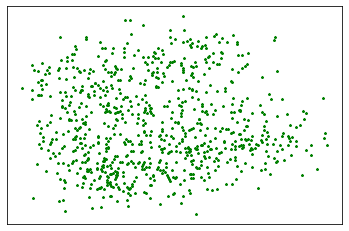

донорство
number of points: 39


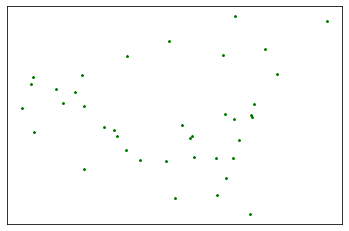

number of points: 30


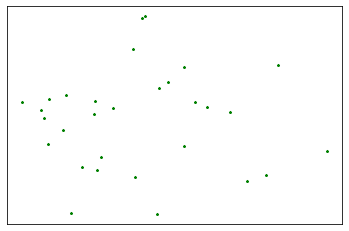

драйвер
number of points: 25


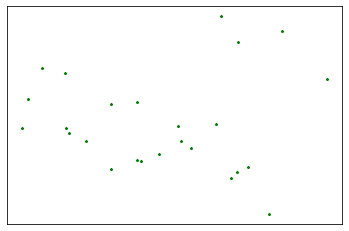

number of points: 100


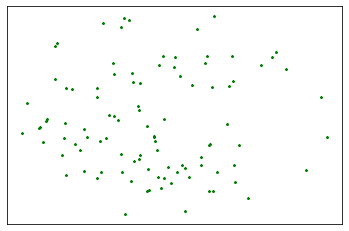

завязка
number of points: 311


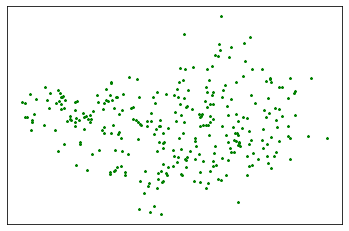

number of points: 351


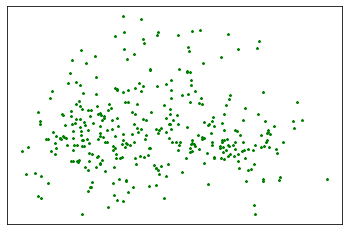

загрузка
number of points: 188


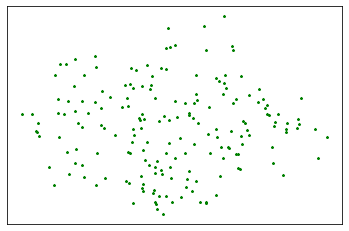

number of points: 689


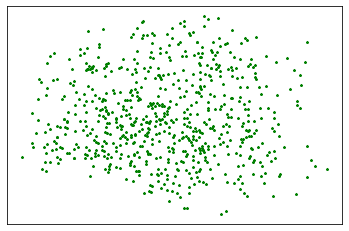

знамя
number of points: 4752


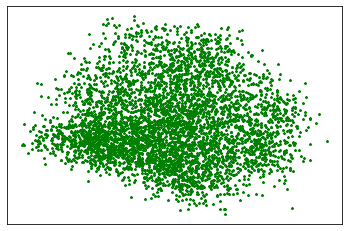

number of points: 2139


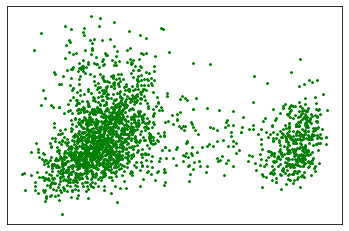

игра
number of points: 13149


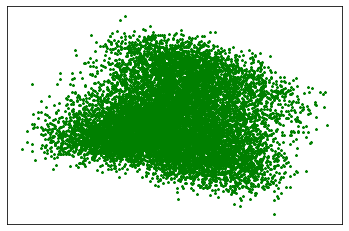

number of points: 16717


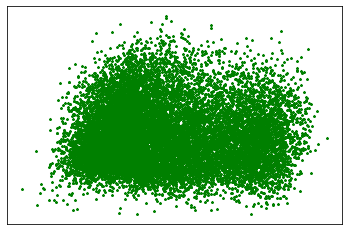

инкубатор
number of points: 215


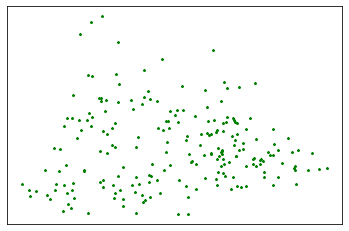

number of points: 83


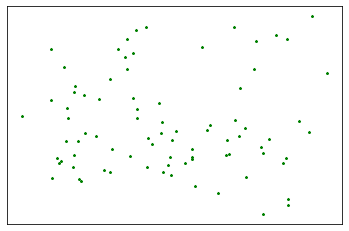

исполнитель
number of points: 1875


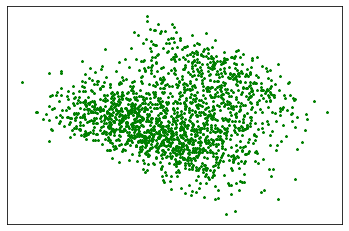

number of points: 3646


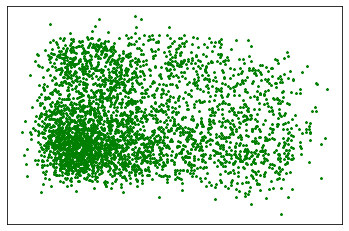

карта
number of points: 9826


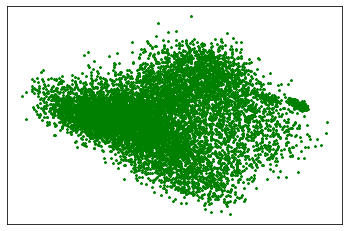

number of points: 9224


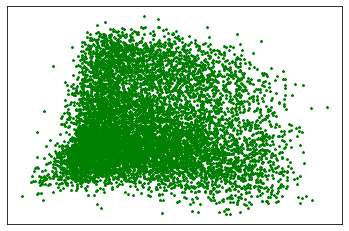

классный
number of points: 1229


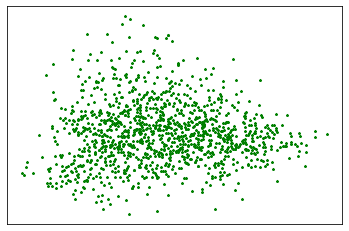

number of points: 1528


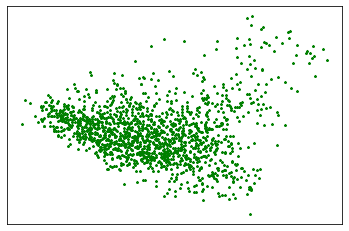

корпус
number of points: 11486


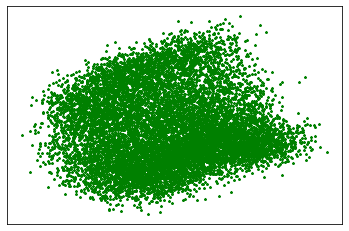

number of points: 5517


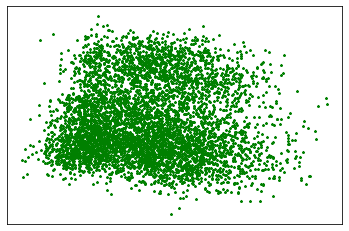

лилипут
number of points: 189


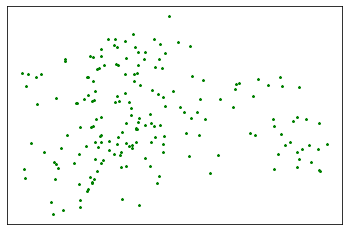

number of points: 172


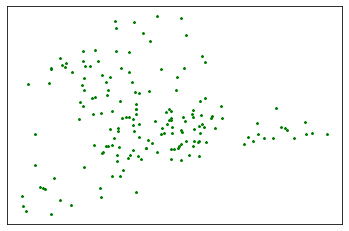

ломберный
number of points: 103


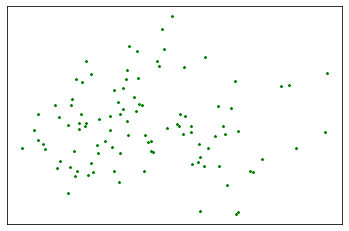

number of points: 50


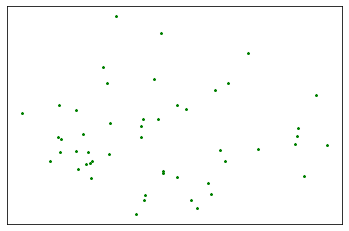

модель
number of points: 3562


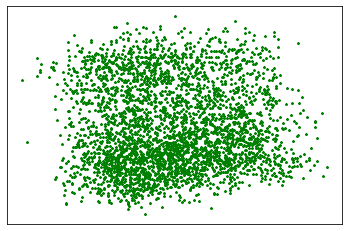

number of points: 14688


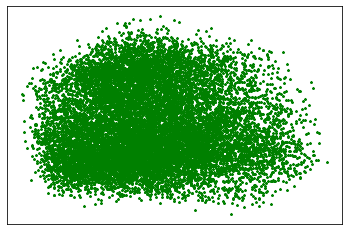

мыло
number of points: 1796


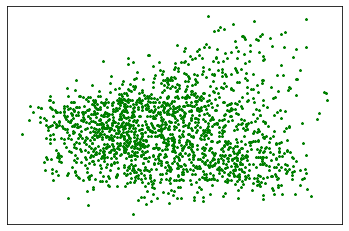

number of points: 1249


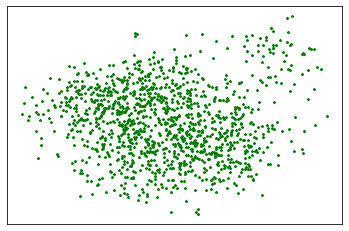

однодневка
number of points: 34


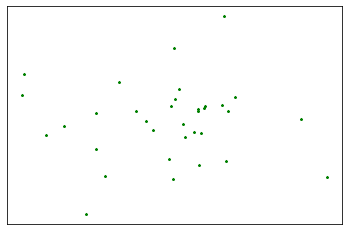

number of points: 81


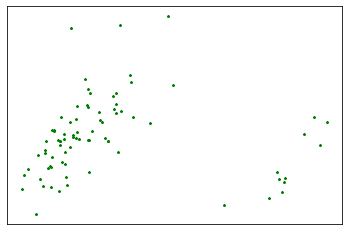

орбита
number of points: 1234


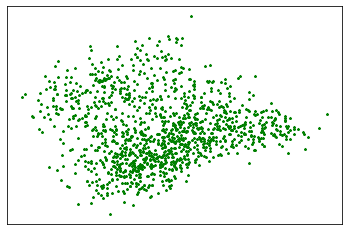

number of points: 1496


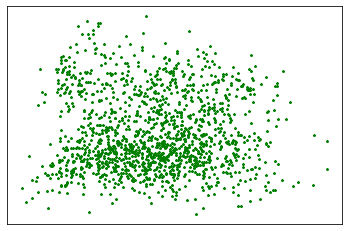

пакет
number of points: 2548


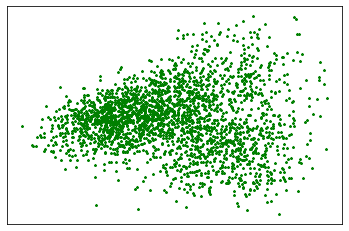

number of points: 6153


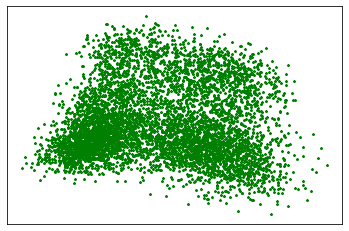

перестройка
number of points: 1352


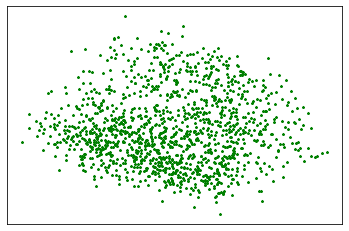

number of points: 2866


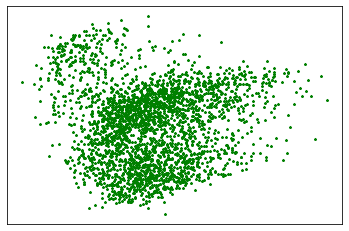

погрешность
number of points: 182


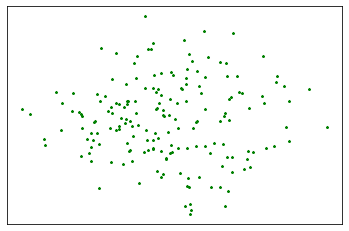

number of points: 438


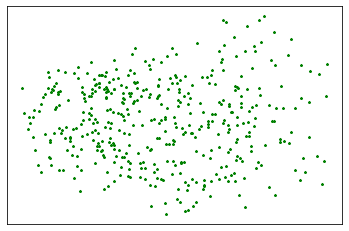

подстава
number of points: 12


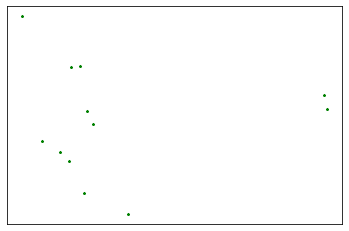

number of points: 109


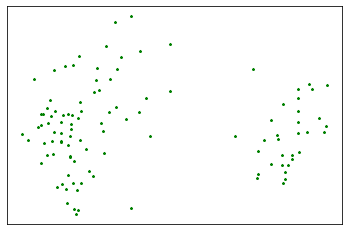

приношение
number of points: 167


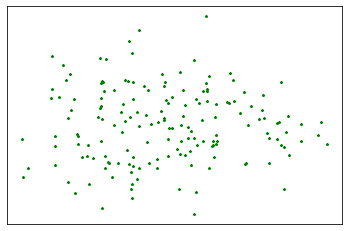

number of points: 80


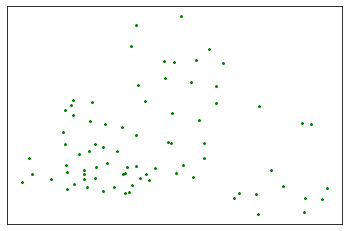

прислуга
number of points: 1606


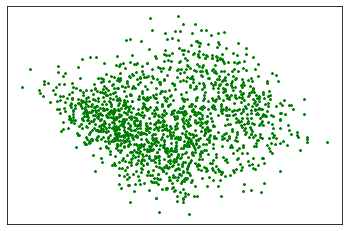

number of points: 470


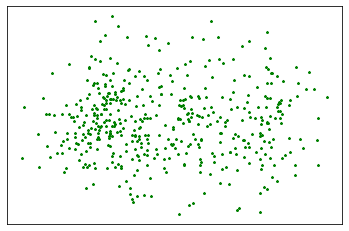

приставка
number of points: 179


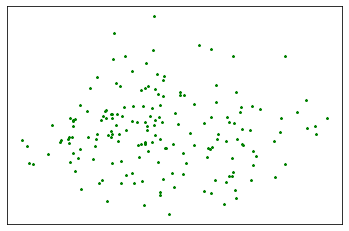

number of points: 327


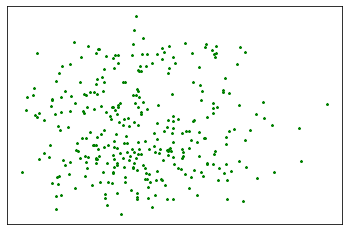

провальный
number of points: 35


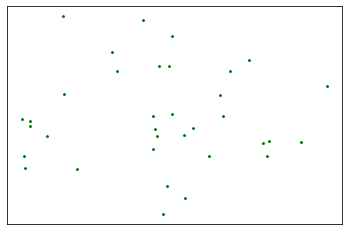

number of points: 161


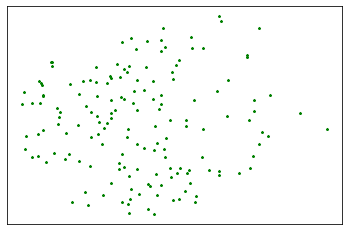

продукция
number of points: 2269


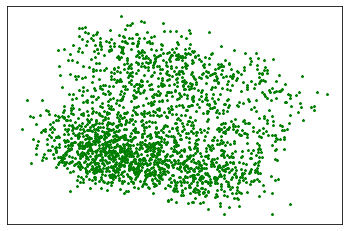

number of points: 12214


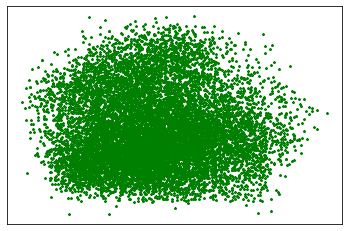

раскрутка
number of points: 19


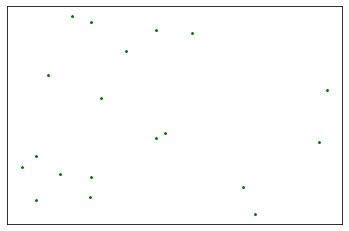

number of points: 249


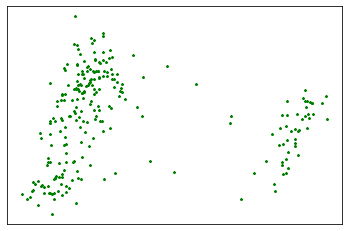

рождество
number of points: 1463


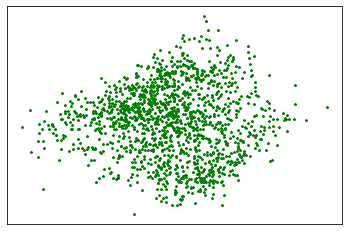

number of points: 1462


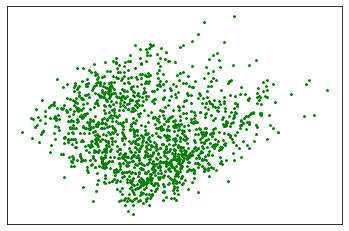

рынок
number of points: 3368


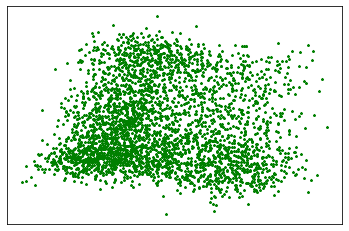

number of points: 30053


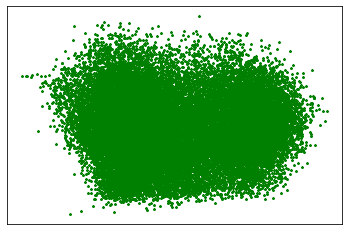

рыночный
number of points: 281


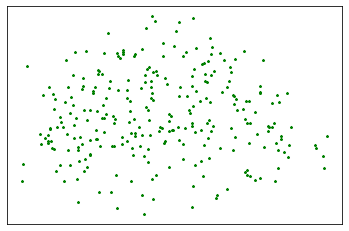

number of points: 4429


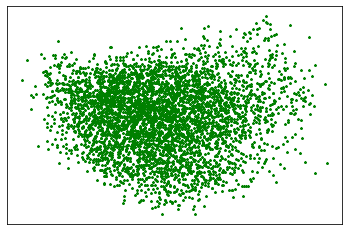

свинцовый
number of points: 1096


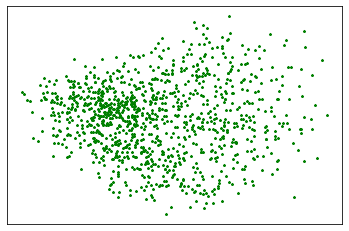

number of points: 486


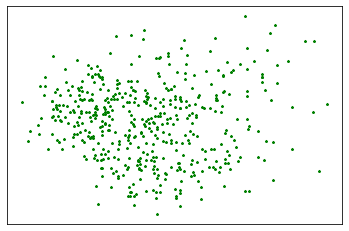

собака
number of points: 16477


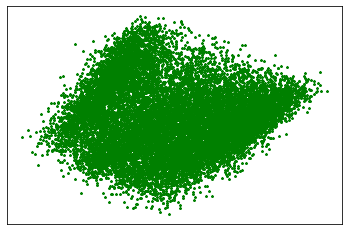

number of points: 10027


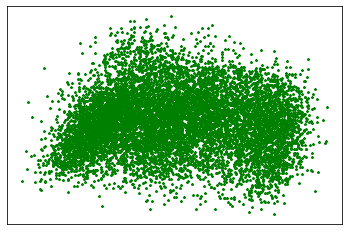

стаканчик
number of points: 863


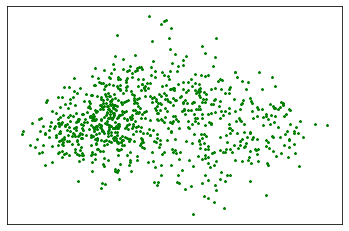

number of points: 629


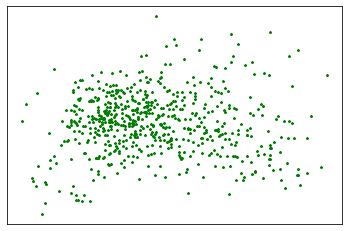

стачка
number of points: 494


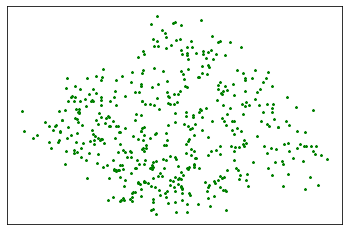

number of points: 88


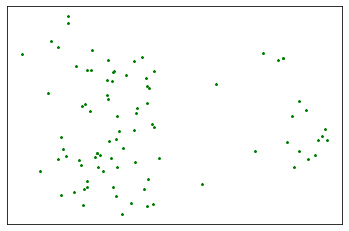

стиль
number of points: 6113


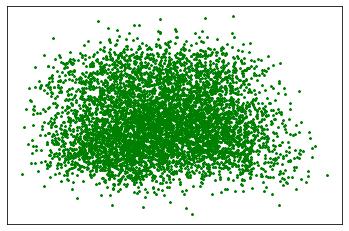

number of points: 8138


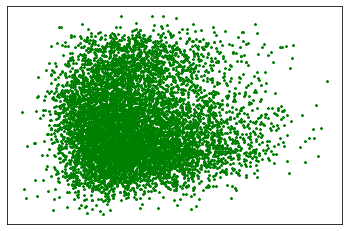

удвоение
number of points: 90


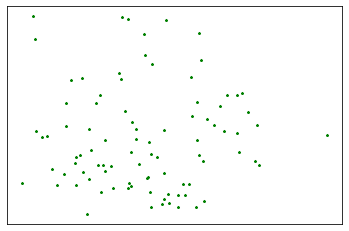

number of points: 386


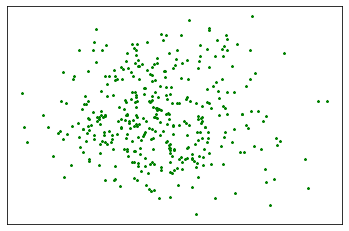

флакон
number of points: 427


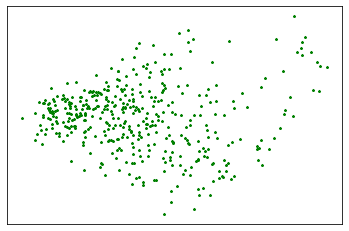

number of points: 577


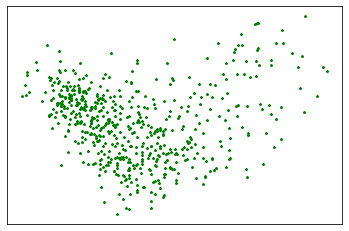

четырехлетка
number of points: 52


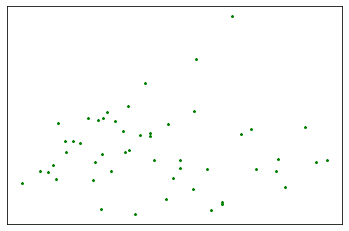

number of points: 11


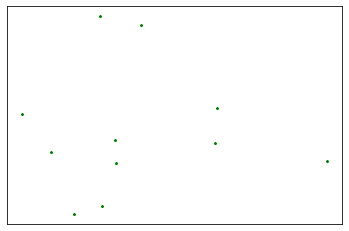

<Figure size 432x288 with 0 Axes>

In [41]:
for word in target_words:
    print(word)
    pic(array0[word])
    pic(array1[word])

### UMAP

In [42]:
import umap
import hdbscan

In [93]:
def umap_cluster(matrix):
    clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
    ).fit_transform(matrix)
    
    
    labels = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=500,
    ).fit_predict(clusterable_embedding)
    
    clustered = (labels >= 0)
    plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
    plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


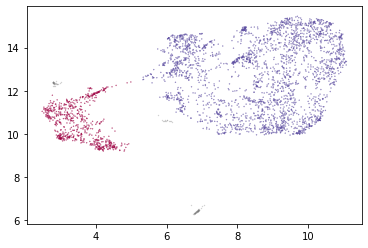

In [102]:
umap_cluster(array0['рынок'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


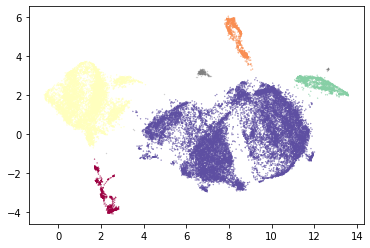

In [103]:
umap_cluster(array1['рынок'])